In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.9.1
Pandas Version: 1.2.1
Numpy Version: 1.20.1
System Version: 3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]


In [2]:
import IPython
import IPython.display

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

In [4]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

## Datos

Los datos son tomados del instituto Max Planck y corresponden a datos climáticos

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Predicción Multivariada

In [6]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [7]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

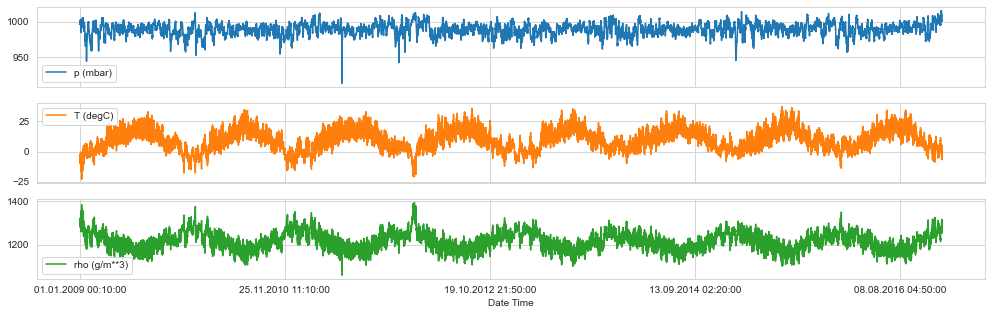

In [8]:
features.plot(subplots=True)

In [9]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
train_df

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.947798,-1.979098,2.215821
01.01.2009 00:20:00,0.953824,-2.024163,2.265873
01.01.2009 00:30:00,0.949003,-2.035718,2.276616
01.01.2009 00:40:00,0.946592,-2.012608,2.250980
01.01.2009 00:50:00,0.946592,-2.007986,2.246341
...,...,...,...
05.08.2014 01:40:00,0.183649,0.631182,-0.619604
05.08.2014 01:50:00,0.211370,0.626560,-0.609838
05.08.2014 02:00:00,0.224628,0.609228,-0.590061


In [12]:
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,p (mbar),0.947798
1,p (mbar),0.953824
2,p (mbar),0.949003
3,p (mbar),0.946592
4,p (mbar),0.946592
...,...,...
1261648,rho (g/m**3),1.855197
1261649,rho (g/m**3),1.768764
1261650,rho (g/m**3),1.743128
1261651,rho (g/m**3),1.869358


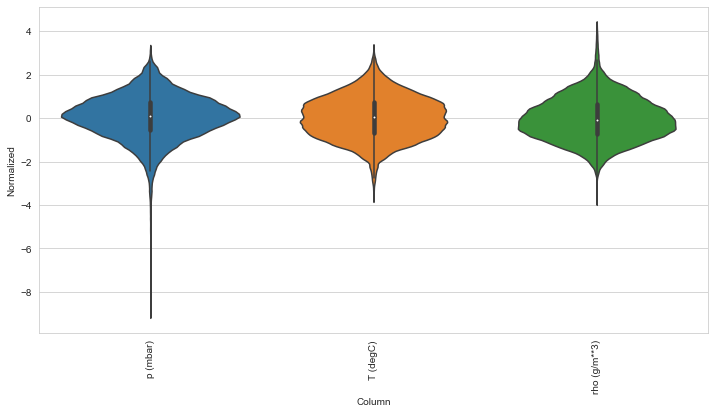

In [13]:

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

### Modelos de salida única

Todos estos modelos se pueden convertir para predecir múltiples funciones simplemente cambiando la cantidad de unidades en la capa de salida y ajustando las ventanas de entrenamiento para incluir todas las funciones en las labels ( example_labels ):

La función windowGenerator, permite implementar la ventana de datos que pueda utilizarse para hacer la predicción según se requiera. Según la tarea y el tipo de modelo, es posible generar una variedad de ventana de datos. Aquí presentamos unos ejemplos:

Por ejemplo, para hacer una sola predicción 4 horas en el futuro(es decir, 24 periodos ya que cada periodo es de 10 minutos), con 4 horas(24 periodos de historial), se puede definir la siguiente ventana:


<img src="24241.png">

Para hacer una sola predicción 10 minutos en el futuro(es decir, 1 periodos ya que cada periodo es de 10 minutos), con 1 hora(6 periodos de historial), se puede definir la siguiente ventana:

<img src="611.png">

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Configuración basados en las últimas 4 horas(24 periodos) y predicción 24 pasos adelante(4 horas) sin predecir las anteriores para la variable temperatura.

Note que la función WindowGenerator tiene de entrada por defecto a :

self.train_df = train_df

self.val_df = val_df

self.test_df = test_df



In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

# Configuración basados en la última hora y predicción un paso adelante para la temperatura.

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Ahora, la función split_window permite convertir la lista de entradas consecutivas en una ventana de entradas y una ventana de etiquetas:

<img src="EjemploDividir.png">

## Ejemplo de tres porciones o slice al incio, en el tiempo 100 y en el timpo 200

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [23]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.93287831]],

       [[-1.65786867]],

       [[-1.5030313 ]]])>

## Visualización

In [24]:
example_inputs 

<tf.Tensor: shape=(3, 6, 3), dtype=float64, numpy=
array([[[ 0.94779765, -1.97909842,  2.21582063],
        [ 0.95382407, -2.02416303,  2.26587334],
        [ 0.94900294, -2.03571805,  2.27661636],
        [ 0.94659237, -2.012608  ,  2.25097961],
        [ 0.94659237, -2.00798599,  2.24634058],
        [ 0.94538709, -1.98256493,  2.21850639]],

       [[ 1.38290453, -1.66826819,  2.00315765],
        [ 1.38772566, -1.6728902 ,  2.00877332],
        [ 1.38772566, -1.67982322,  2.01683058],
        [ 1.38893094, -1.66249068,  1.99900693],
        [ 1.38893094, -1.65440216,  1.99021719],
        [ 1.38772566, -1.65440216,  1.99046135]],

       [[ 1.19005938, -1.5030313 ,  1.77682173],
        [ 1.19729107, -1.5030313 ,  1.77901916],
        [ 1.19608579, -1.50534231,  1.78219324],
        [ 1.20452276, -1.50649781,  1.78487899],
        [ 1.22019143, -1.51111982,  1.79342458],
        [ 1.22621784, -1.50649781,  1.79098298]]])>

In [25]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.93287831]],

       [[-1.65786867]],

       [[-1.5030313 ]]])>

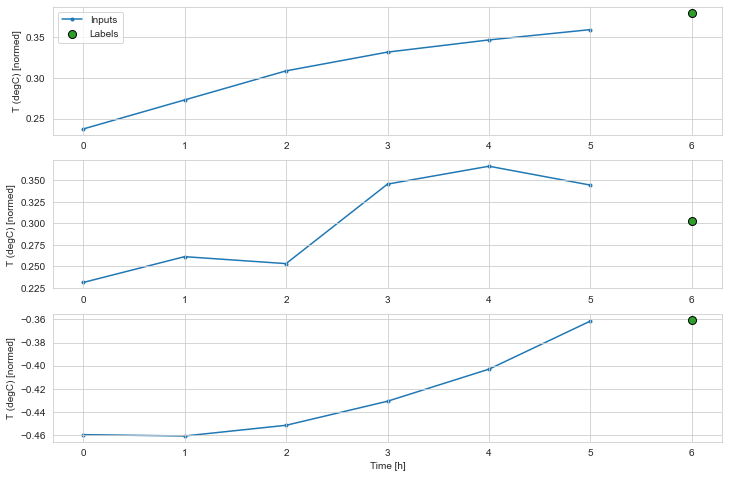

In [26]:
w2.plot()

## Las otras columnas

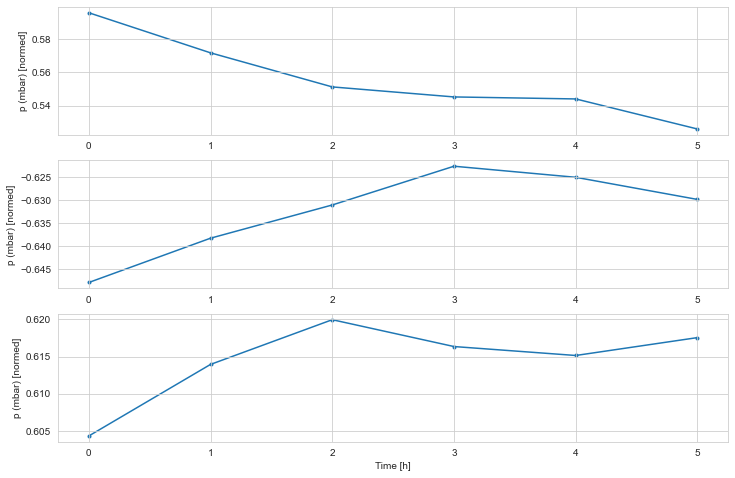

In [27]:
w2.plot(plot_col='p (mbar)')

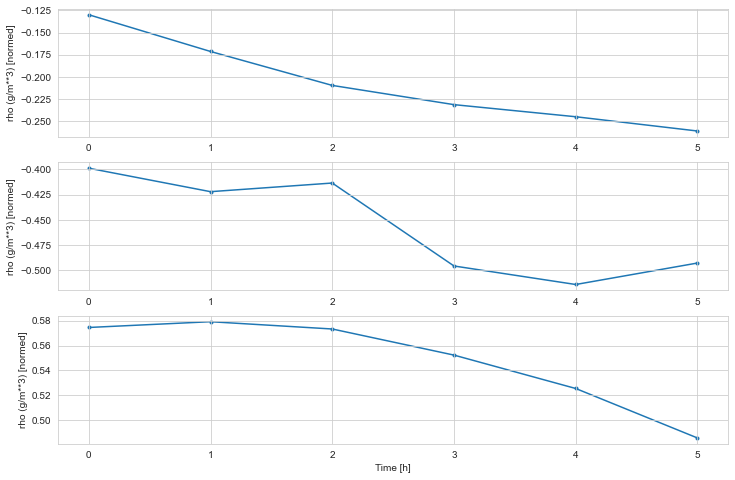

In [28]:
w2.plot(plot_col='rho (g/m**3)')

## Crear objeto tensorflow

El método mahe_dataset tomará un data frame de serie temporal y lo convertirá en un tf.data.Dataset de (input_window, label_window) usando la función tf.keras.utils.timeseries_dataset_from_array. el objeto WindowGenerator contiene datoas de entrenamiento, validación y prueba.

In [29]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


Se itera sobre el conjunto Dataset para producir lotes concretos

## Modelos de un solo paso

El modelo mas simple se puede crear a partir de este tipo de datos, y es que le predice el valor de una sola característica: 1 paso de tiempo(10 minutos) hacia el futuro basandose únicamente en las condicionea actuales, es decir, basados en la información inmediantamente anterior:

In [31]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)



El modelo base, es un modelo simple, es decir, la predicción un paso adelante de la temperatura actual es la actual temperatura, ya que la temperatura no cambia drámaticamente en un periodod e 10 minutos.

### Modelo Base

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [49]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2629/2629 [==============================] - 2s 706us/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


## Modelo de mas grande ventana

Esto permite evaluar mas detalladamente la evolución del comportamineto del modelo.

In [50]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,label_columns=['T (degC)'])


wide_window



Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [51]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 24, 1)


In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


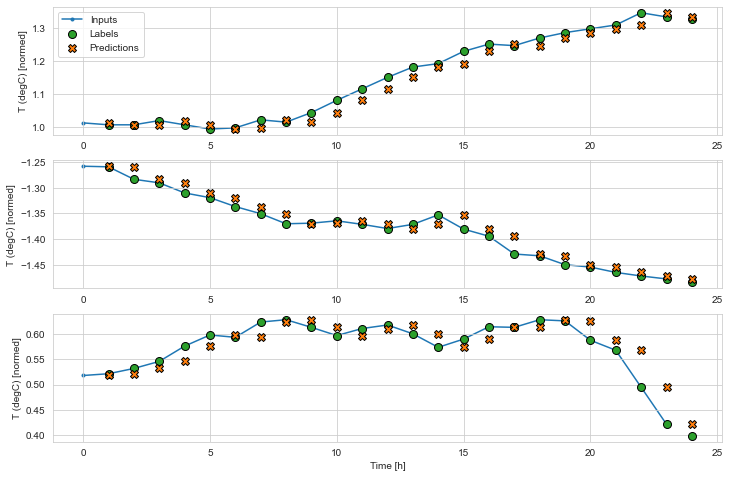

In [53]:
wide_window.plot(baseline)

In [54]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

2628/2628 [==============================] - 2s 740us/step - loss: 7.7096e-04 - mean_absolute_error: 0.0180


## Denso(MLP)

In [55]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
9200/9200 [==============================] - 11s 986us/step - loss: 0.0024 - mean_absolute_error: 0.0240 - val_loss: 8.1621e-04 - val_mean_absolute_error: 0.0193
Epoch 2/5
9200/9200 [==============================] - 9s 1ms/step - loss: 9.5366e-04 - mean_absolute_error: 0.0213 - val_loss: 8.8792e-04 - val_mean_absolute_error: 0.0208
Epoch 3/5
2629/2629 [==============================] - 2s 729us/step - loss: 8.5147e-04 - mean_absolute_error: 0.0200


## RNN(LSTM)

In [56]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [57]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


In [58]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2628/2628 [==============================] - 5s 2ms/step - loss: 5.2271e-04 - mean_absolute_error: 0.0144


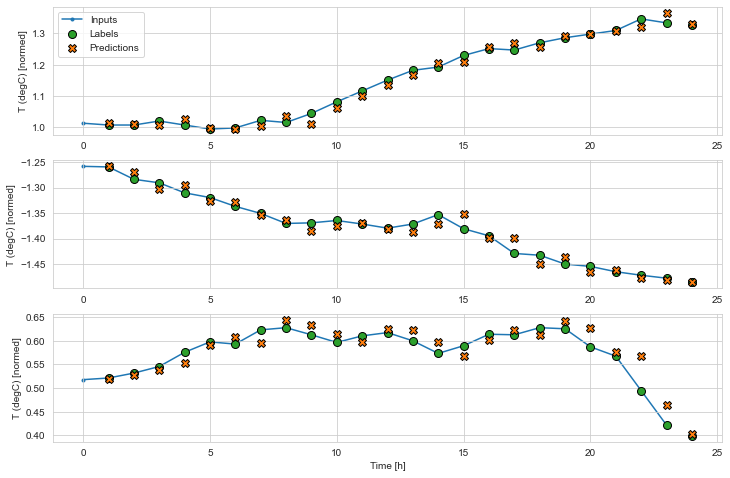

In [59]:
wide_window.plot(lstm_model)

## Rendimiento

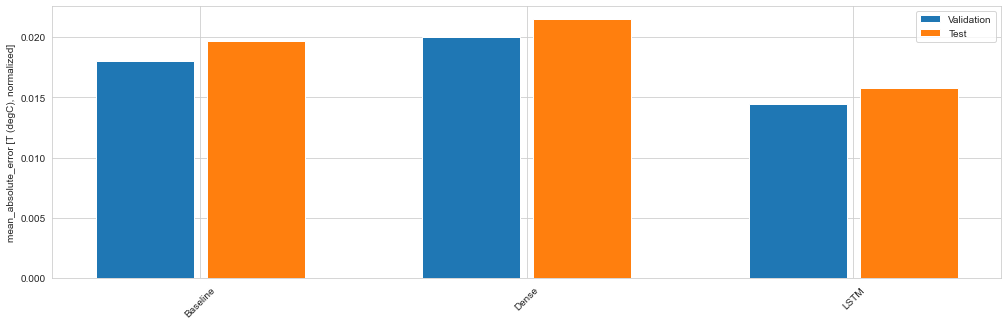

In [60]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


# Mútiples Salidas

Los modelos anteriores se pueden usar para predecir mas de una sola salida, en vez de predecir únicamente la temperatura(T (degC)),  procederemos a predecir 'p (mbar)', 'T (degC)', 'rho (g/m**3)' al mismo tiempo, la presión del aire, temperatura y la densidad del aire. Se debe cambiar las unidades de la capa de salida y ajustando la ventana de entrenamineto para incluir las funciones en las labels. Note que ahora la salida es 3.

In [62]:
# Esta configuración consiste en que solo la última información 
#es usada para predecir el siguiente paso adelante. Note que batch es 32.

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)


# Esta configuración consiste en que los últimos 24 periodos de información 
#es usada para predecir el siguiente paso adelante. Note que batch es 32.
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 24, 3)


In [70]:
single_step_window.example[0] 

<tf.Tensor: shape=(32, 1, 3), dtype=float32, numpy=
array([[[-1.6122217 , -0.46192336,  0.00422327]],

       [[-0.8854366 , -0.37526065,  0.10335205]],

       [[-1.7857823 , -0.24353334, -0.22675169]],

       [[-0.12369823,  0.85881627, -0.9079569 ]],

       [[-1.3518808 , -1.0408303 ,  0.6446538 ]],

       [[ 0.81401134, -0.19846874,  0.3719276 ]],

       [[-1.8086828 ,  1.2482207 , -1.6082065 ]],

       [[-1.583295  ,  0.72131145, -1.0888791 ]],

       [[ 0.16195366,  0.4463018 , -0.4452745 ]],

       [[-0.24181588,  0.04996434, -0.15765452]],

       [[-0.7552661 , -0.30130848,  0.07454123]],

       [[-0.67812806,  0.531809  , -0.6838184 ]],

       [[ 0.24752869,  0.7513545 , -0.67551696]],

       [[ 0.4030101 ,  2.5966923 , -2.1775866 ]],

       [[ 0.67901975, -0.18922472,  0.3379894 ]],

       [[ 0.73928386,  0.43705776, -0.26801464]],

       [[ 0.06673636,  0.68433535, -0.6891899 ]],

       [[ 0.48617458,  0.14933757, -0.01091462]],

       [[-1.574858  , -0.62138

In [71]:
wide_window.example[0]

<tf.Tensor: shape=(32, 24, 3), dtype=float32, numpy=
array([[[-0.891463  , -0.7635096 ,  0.49058914],
        [-0.90231055, -0.75079906,  0.47545123],
        [-0.9071317 , -0.748488  ,  0.47252133],
        ...,
        [-1.0758711 , -0.7080454 ,  0.39146036],
        [-1.1011821 , -0.71382296,  0.39072788],
        [-1.1228771 , -0.6722249 ,  0.34507003]],

       [[ 2.512254  , -2.5302732 ,  3.2395816 ],
        [ 2.520691  , -2.5279622 ,  3.2393374 ],
        [ 2.5218961 , -2.5221846 ,  3.2332335 ],
        ...,
        [ 2.619524  , -2.3777468 ,  3.1026082 ],
        [ 2.6183188 , -2.3661919 ,  3.0896678 ],
        [ 2.6315768 , -2.3488593 ,  3.0742857 ]],

       [[-0.5672421 ,  0.68433535, -0.75340384],
        [-0.553984  ,  0.6658473 , -0.73362696],
        [-0.5515734 ,  0.6415817 , -0.7116526 ],
        ...,
        [-0.5431364 , -0.05056439, -0.09270808],
        [-0.54193115, -0.08869598, -0.05779326],
        [-0.5298783 , -0.10371751, -0.04241121]],

       ...,

       

## Modelo Base

Usaremos el modelo base anterior.

In [63]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [64]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

2628/2628 [==============================] - 2s 701us/step - loss: 5.3296e-04 - mean_absolute_error: 0.0147


## Modelo Denso(MLP)

In [66]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [67]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

2629/2629 [==============================] - 2s 696us/step - loss: 6.8215e-04 - mean_absolute_error: 0.0179


## Red Neuronal Recurrente(LSTM)

In [68]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

2628/2628 [==============================] - 5s 2ms/step - loss: 3.6944e-04 - mean_absolute_error: 0.0119

CPU times: user 10min 42s, sys: 2min 17s, total: 12min 59s
Wall time: 4min 35s


## Rendimiento

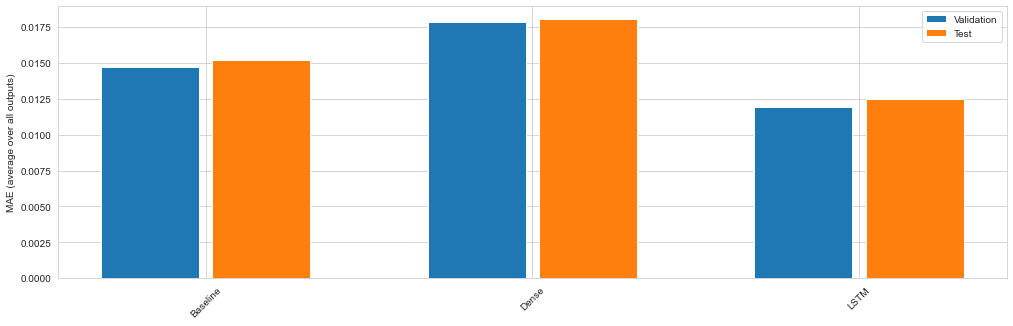

In [69]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# Varios pasos adelante

Hay dos enfoques aproximados para esto:

1) Predicciones de disparo único donde se predice la serie temporal completa a la vez.

2) Predicciones autorregresivas donde el modelo solo hace predicciones de un solo paso y su salida se retroalimenta como su entrada.

Para el modelo de varios pasos, los datos de entrenamiento nuevamente consisten en muestras por 10 minutos. Sin embargo, aquí, los modelos aprenderán a predecir 24 periodos(4 horas) en el futuro, dadas las 24 periodos del pasado(4 horas).

Aquí hay un objeto de Window que genera estos segmentos a partir del conjunto de datos:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

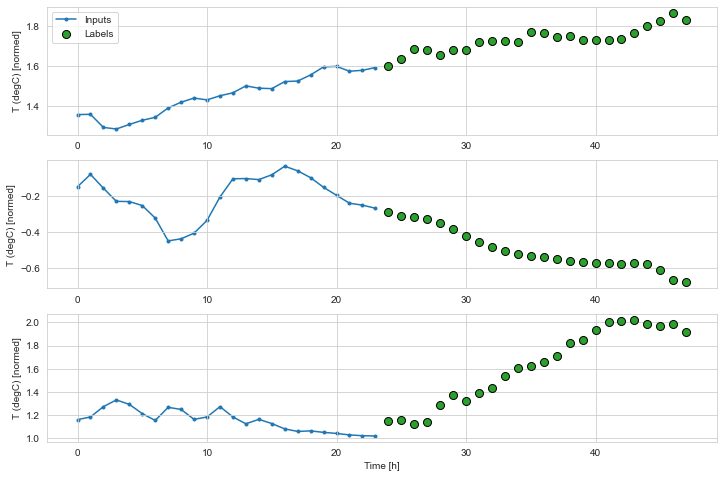

In [72]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window
## Note que el nombre del eje Y está mal.

# Modelo Línea de base

Una línea de base simple para esta tarea es repetir el último paso de tiempo de entrada para el número requerido de pasos de tiempo de salida:
 <img src="LineadeBase.png">

2627/2627 [==============================] - 2s 735us/step - loss: 0.0363 - mean_absolute_error: 0.1210


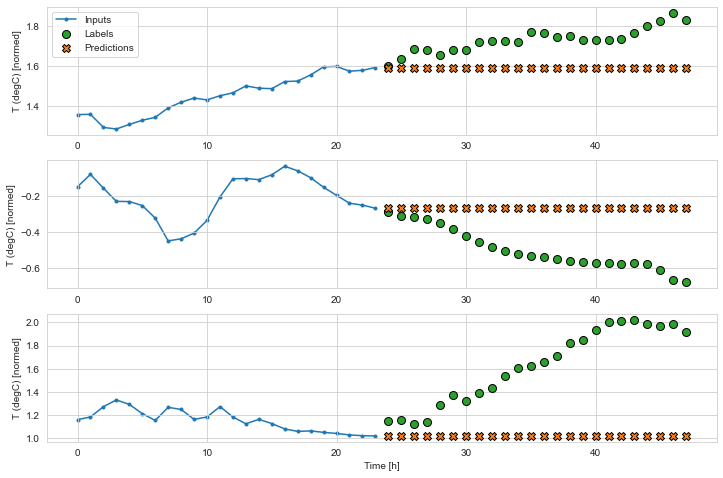

In [73]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Dado que esta tarea es predecir 24 periodos en el futuro, dadas las 24 periodos del pasado, otro enfoque simple es repetir el las 4 horas anteriores, asumiendo que lñas 4 horas siguientes será similar:

2627/2627 [==============================] - 2s 822us/step - loss: 0.0904 - mean_absolute_error: 0.2165


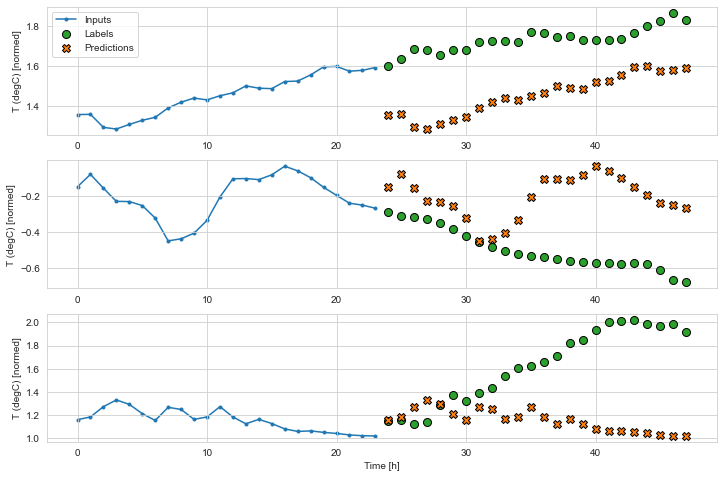

In [74]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Modelos de Disparo Único

Un enfoque de alto nivel para este problema es usar un modelo de "disparo único", donde el modelo realiza la predicción de secuencia completa en un solo paso. Esto se puede implementar de manera eficiente como unidades de salida tf.keras.layers.Dense con OUT_STEPS*features . El modelo solo necesita remodelar esa salida según lo requerido (OUTPUT_STEPS, features) .



# Modelo Lineal

 <img src="ModeloLineal.png">

2627/2627 [==============================] - 2s 719us/step - loss: 0.0351 - mean_absolute_error: 0.1225


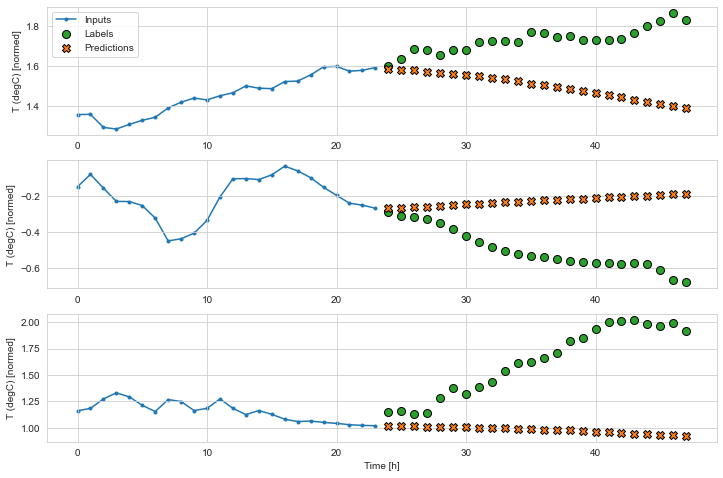

In [75]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Denso(MLP)

Se agrega una capa Densa con función de activación relu

2627/2627 [==============================] - 2s 840us/step - loss: 0.0344 - mean_absolute_error: 0.1228


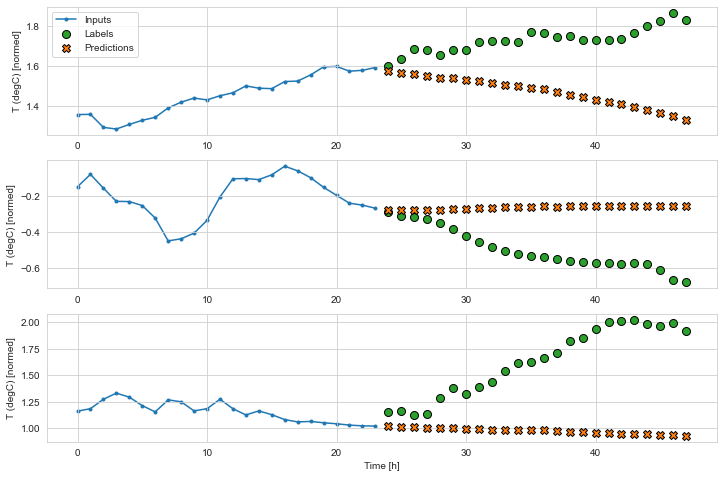

In [76]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# Convolucional 

La red MLP se basa únicamnente en el pasado reciente(último dato) para predecir el futuro. Un modelo convolucional hace predicciones basadas en un historial de ancho fijo, lo que puede conducir a un mejor rendimiento que el modelo denso, ya que puede ver cómo cambian las cosas con el tiempo, para este caso se toma los útimos 24 periodos:
<img src="CNN.png">


2627/2627 [==============================] - 2s 772us/step - loss: 0.0226 - mean_absolute_error: 0.0991


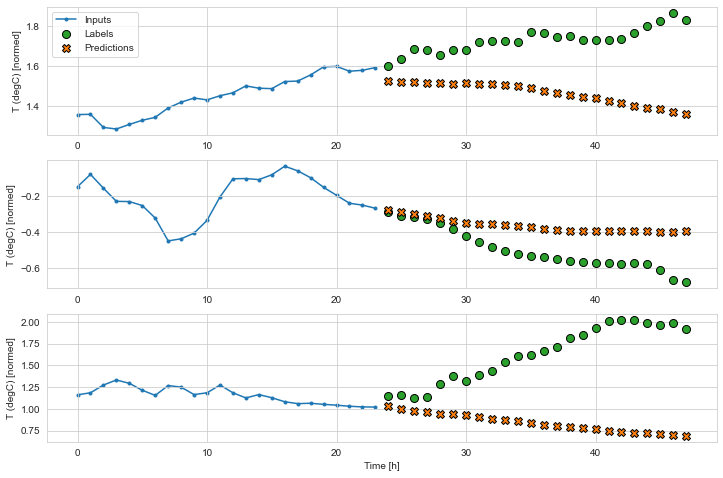

In [78]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# Red Neuronal Recurrente

Un modelo recurrente puede aprender a usar un largo historial de entradas, si es relevante para las predicciones que hace el modelo. Aquí el modelo acumulará el estado interno durante 24 horas, antes de hacer una sola predicción para las próximas 24 horas.

En este formato de disparo único, el LSTM solo necesita producir una salida en el último paso de tiempo, por lo tanto, establezca return_sequences=False en tf.keras.layers.LSTM .

<img src="RNNMutiple.png">

2627/2627 [==============================] - 5s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.0915


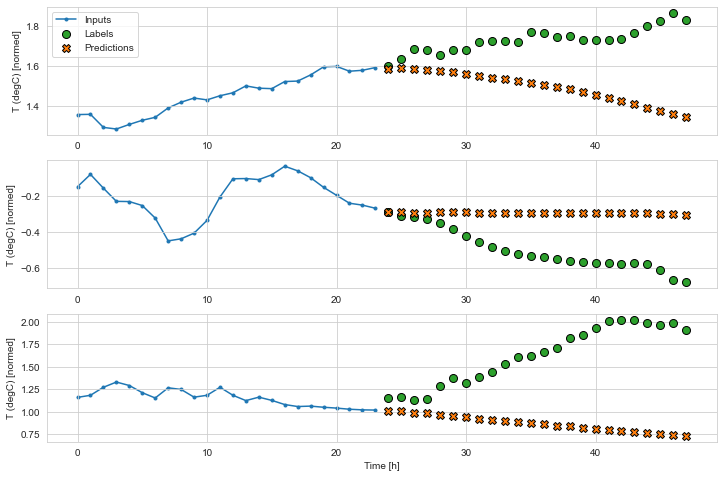

In [79]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Avanzado: modelo autorregresivo

Todos los modelos anteriores predicen la secuencia de salida completa en un solo paso.

En algunos casos, puede ser útil para el modelo descomponer esta predicción en pasos de tiempo individuales. Luego, la salida de cada modelo se puede retroalimentar en cada paso y se pueden hacer predicciones condicionadas a la anterior, como en el clásico Generating Sequences With Recurrent Neural Networks .

Una clara ventaja de este estilo de modelo es que se puede configurar para producir resultados con una longitud variable.

Puede tomar cualquiera de los modelos de salida múltiple de un solo paso entrenados en la primera mitad de este tutorial y ejecutarlo en un ciclo de retroalimentación autorregresivo, pero aquí se concentrará en crear un modelo que haya sido entrenado explícitamente para hacer eso.

<img src="ModeloAutoregresivoRNN.png">

En este caso, el modelo tiene que administrar manualmente las entradas para cada paso, por lo que usa tf.keras.layers.LSTMCell directamente para la interfaz de paso de tiempo único de nivel inferior.

In [80]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [81]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un método de warmup para inicializar su estado interno en función de las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entrada. Esto es equivalente al modelo LSTM de un solo paso anterior:

In [82]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [83]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 3])

Con el estado de RNN y una predicción inicial, ahora puede continuar iterando el modelo alimentando las predicciones en cada paso hacia atrás como entrada.

El enfoque más simple para recopilar las predicciones de salida es usar una lista de Python y un tf.stack después del bucle.

In [84]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [85]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 3)


Ahora, entrena el modelo:

2627/2627 [==============================] - 8s 3ms/step - loss: 0.0242 - mean_absolute_error: 0.1006


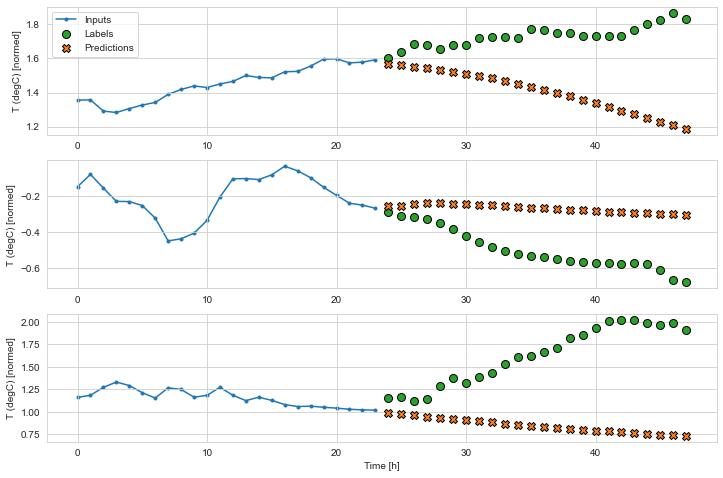

In [87]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Rendimiento

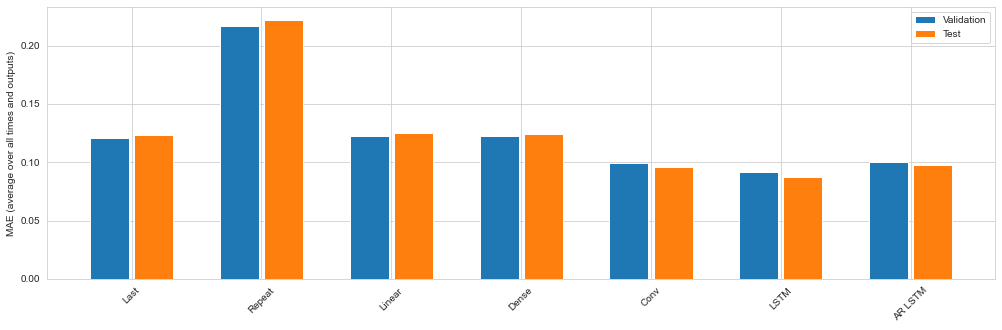

In [88]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()